<a href="https://colab.research.google.com/github/PraveenRaja42/DQN-on-Pong-Environment/blob/main/Ch4_PolicyGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning <em> in Action </em> 
## Ch. 4 - Policy Gradients

In [1]:
from gym import envs


In [ ]:
import gym
import numpy as np
import torch
from matplotlib import pylab as plt

In [ ]:
env = gym.make("CartPole-v0")

In [ ]:
print(env.observation_space)

Box(4,)


#### Helper functions

In [ ]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

#### Defining Network

In [ ]:
l1 = 4
l2 = 150
l3 = 2

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Objective Function

In [ ]:
def loss_fn(preds, r): 
    # pred is output from neural network, a is action index
    # r is return (sum of rewards to end of episode), d is discount factor
    return -torch.sum(r * torch.log(preds)) # element-wise multipliy, then sum

#### Training Loop

In [ ]:
env = gym.make('CartPole-v0')
MAX_DUR = 200
MAX_EPISODES = 500
gamma_ = 0.2
time_steps = []
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # list of state, action, rewards
    
    for t in range(MAX_DUR): #while in episode
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, reward, done, info = env.step(action)
        transitions.append((prev_state, action, reward))
        if done:
            break

    # Optimize policy network with full episode
    ep_len = len(transitions) # episode length
    time_steps.append(ep_len)
    preds = torch.zeros(ep_len)
    discounted_rewards = torch.zeros(ep_len)
    for i in range(ep_len): #for each step in episode
        discount = 1
        future_reward = 0
        # discount rewards
        for i2 in range(i, ep_len):
            future_reward += transitions[i2][2] * discount
            discount = discount * gamma_
        discounted_rewards[i] = future_reward
        state, action, _ = transitions[i]
        pred = model(torch.from_numpy(state).float())
        preds[i] = pred[action]
    loss = loss_fn(preds, discounted_rewards)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
env.close()

C:\Users\91950\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


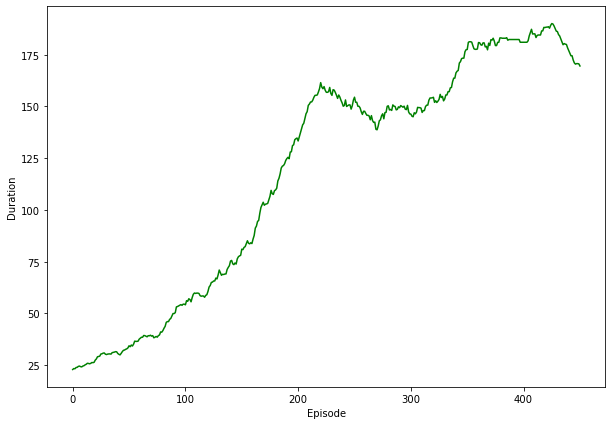

In [ ]:
plt.figure(figsize=(10,7))
plt.ylabel("Duration")
plt.xlabel("Episode")
plt.plot(running_mean(time_steps, 50), color='green')